## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. let's read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. check the number of dataset's rows:

In [3]:
rows = int(df.user_id.count())
print("Number of rows is :",rows )

Number of rows is : 294478


c. The number of unique users in the dataset.

In [4]:
users = df.nunique()['user_id']
print("Number of users is :",users )


Number of users is : 290584


d. The proportion of users converted.

In [5]:
conv_rate = df.converted.mean()
print("Conversion rate is :",conv_rate )

Conversion rate is : 0.119659193556


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [7]:
trt_notmatch= (df.query('group == "treatment" ')['landing_page'] != "new_page").sum()
trt_notmatch

1965

In [8]:
newpg_notmatch = (df.query('landing_page == "new_page" ')['group'] != "treatment").sum()
newpg_notmatch

1928

In [9]:
print("The number of times the new_page and treatment don't match is :",trt_notmatch+newpg_notmatch)

The number of times the new_page and treatment don't match is : 3893


f. Do any of the rows have missing values?

In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

it's clear that there is no null values

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now let's create a new df that have only trusted data (calling it **df2**).

In [11]:
# we will remove all not match rows as it's confusing and hard to be used 
#get the not match treatment and new page
df_trt_nm = df[(df.group == "treatment")&(df.landing_page != "new_page")]
#get the not match control and old page
df_ctrl_nm = df[(df.group =="control")&(df.landing_page != "old_page")]

In [12]:
#combining both in one df to be dropped from the original df
df_not_match = df_trt_nm.append(df_ctrl_nm)
#getting the index of the desired rows to remove
delete_idx = df_not_match.index
df_not_match.shape

(3893, 5)

In [13]:
#remove from the original df and create the new df2
df2 = df.drop(delete_idx)
df2.shape

(290585, 5)

In [14]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` let's use **df2** to answer some oroposed questions 

a. How many unique **user_id**s are in **df2**?

In [15]:
df.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [16]:
dup = int(df2[df2.user_id.duplicated()]['user_id'])
print("Duplicated user_id is :",dup)

Duplicated user_id is : 773192


c. What is the row information for the repeat **user_id**? 

In [17]:
df2[df2.user_id.duplicated(keep=False)]
#https://appdividend.com/2020/03/07/python-pandas-find-duplicate-rows-in-dataframe-based-on-all-or-selected-columns/#:~:text=duplicated()%20is%20an%20inbuilt,columns%2C%20then%20use%20the%20pandas.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, keeping dataframe as **df2**.

#### Since the duplicated id have the same group,page and converted vlue , so we can remove any one of them

In [18]:
#let's drop one duplicate
df2 = df2.drop_duplicates(subset = 'user_id', keep = 'first')
#let's check if duplication is already removed
sum(df2.user_id.duplicated())

0

`4.` Let's dive deeper into df2 answering conversion related questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
print("Absolute prop. of convertion :", df2.converted.mean())

Absolute prop. of convertion : 0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
prob_ctrl = df2[df2["group"]=='control'].converted.mean()
print("Prob. of conversion given the group is control:",prob_ctrl)

Prob. of conversion given the group is control: 0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
prob_trt = df2[df2["group"]=='treatment'].converted.mean()
print("Prob. of conversion given the group is treatment:",prob_trt )

Prob. of conversion given the group is treatment: 0.118808065515


d. What is the probability that an individual received the new page?

In [22]:
prob_new = len(df2[df2["landing_page"]=='new_page'])/len(df2.landing_page)
print("Prob. of getting the new_page:",prob_new )

Prob. of getting the new_page: 0.5000619442226688


e. Considering results from parts (a) through (d) above, to check if there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer**
1. The difference between both groups conversions is less than 0.5%, so it's difficult to decide if the new page works well.
2. However , it's sill the treament gruop conversion average is less than the control group (which might indicate we are not on the right way, but not a final decision)
3. Commenting on the data , i see that the data is very sufficient as a count even after removing conflicts and duplicates
4. Also the users is almost devided equally between the two kinds of pages ,which is perfect.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, let's consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? 

- Null hypothesis : old page conversion rate is larger than or equal to new page conversion rate.
- Alternative Hypothesis : new page's conversion rate is greater than old page's one.

`2.` Assumed under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

- Used a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

- Get the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [23]:
#under null hypothesis P_new = P_old
p_new = p_old = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
n_new = len(df2.query('landing_page == "new_page" '))
#or
#n_new = len(df2.query('group == "treatment" '))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old = len(df2.query('landing_page == "old_page" '))
#or
#n_old = len(df2.query('group == "control" '))
#or
#n_old = len(df2.query('landing_page !="new_page" '))
n_old

145274

e. Let's simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

mean is : 0.119991741793


(array([ 127874.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   17436.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

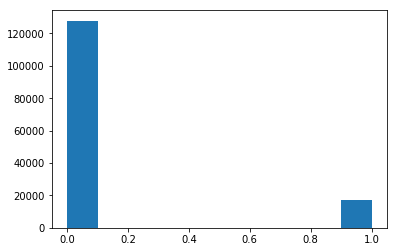

In [27]:
new_page_converted = np.random.binomial(1,p_new,n_new)
#let's check the histogram and mean of simulated new page conversion
print('mean is :', new_page_converted.mean())
plt.hist(new_page_converted)

f. Let's simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

mean is : 0.119587813373


(array([ 127901.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   17373.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

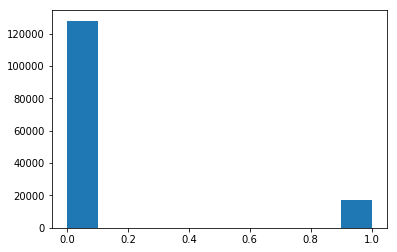

In [28]:
old_page_converted = np.random.binomial(1,p_old,n_old)
#let's check the histogram and mean of simulated old page conversion
print('mean is :', old_page_converted.mean())
plt.hist(old_page_converted)

g. Find $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [29]:
new_page_converted.mean()-old_page_converted.mean()

0.00040392842005752827

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in parts (a) through (g) above. All 10,000 values will be stored in a NumPy array called **p_diffs**.

In [30]:
#bootstraping
# p_diffs = []
# for i in range(10000):
#     # converted_new = np.random.binomial(1,p_new,n_new).mean()
#     # converted_old = np.random.binomial(1,p_old,n_old).mean()
#     # p_diffs.append(converted_new -converted_old)
converted_new = np.random.binomial(n_new, p_new, 10000)/n_new
converted_old = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plotting a histogram of the **p_diffs**.  Does this plot look like what is expected?

Text(0.5,1,'Difference of simulauted new_page & old_page convertions under null hypothesis')

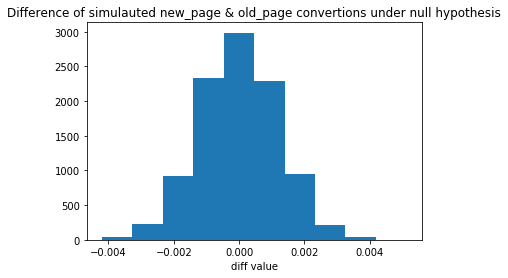

In [31]:
#plotting ditribution of diffs
plt.hist(p_diffs)
plt.xlabel('diff value')
plt.title('Difference of simulauted new_page & old_page convertions under null hypothesis')

- Yes, the histogram is just as expcted , why ?
- Because we have made this ditribution under null hypothesis where p_old(the mean of old page's convertion rate) = p_new (the mean of new page's convertion rare) , which means that the difference distribution should be focused mainly at zero as we see in the above histogram

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

observed difference is : -0.00157823898536


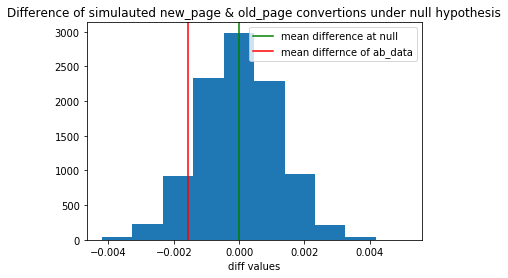

In [32]:
#getting the observed diferernce using the treament& & control conversion means 
#which were calculated at 4.b and 4.c in section I.
obs_diff = prob_trt-prob_ctrl
print('observed difference is :',obs_diff)

#plot mean diff on Null and observed diff 
plt.hist(p_diffs);
plt.title('Difference of simulauted new_page & old_page convertions under null hypothesis')
plt.xlabel('diff values')
plt.axvline(x=p_diffs.mean(), color='g', linewidth=1.5, label='mean difference at null')
plt.axvline(x=obs_diff, color='r', linewidth=1.5, label='mean differnce of ab_data')
plt.legend()



In [33]:
#get the proportion where p_diffs is larger than observed difference
(p_diffs > obs_diff).mean()

0.90700000000000003

k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**
- the above calaculated value of 0.904 is called p-value , meanning that the probability of observing our target statistic in case of true null hypothesis , would be ~0.90.
- This computed p-value is much larger than the signficant p-value(alpha) which is .05 is our case 
- in terms of old/new pages difference , this means that there no advantage for the new page over the old page , even the old page is slightly better , so we couldn't reject the null hypothesis (which is using the old page mainly)


l. We could also use a built-in function to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Let's calculate `n_old` and `n_new` refering the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [35]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

m. Now let's use `stats.proportions_ztest` to compute our test statistic and p-value.

In [36]:
#as in documentaion , we used 'smaller' as our alternative is when
#p_old < p_new, respectively

z_score,p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score,p_value

(1.3109241984234394, 0.90505831275902449)

In [37]:
#getting the critical z-score value for the condifence of 95% (1-aplha= 1-0.05)
#to check if the resutled z-score is lower than critical (so no significacne and couldn't reject null hypothesis)
#or vice versa
from scipy.stats import norm
print('critical z-score is :',norm.ppf(1-(0.05)))

critical z-score is : 1.64485362695


n. What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**

- z-score of 1.3 means that our observed statistic here lies above 1.3 times of standard deviation from the mean , while having a critical z-score of 1.65 means that to have significint statistic(reject null hypothesis) our statistic should lie bove 1.65 times of standared deviation from the mean.
- Thus according to the above statement we couldn't reject null hypothesis , which is also supported by the computed p-value of .91 which is much greater than aplha (also leading not to reject null hypothesis
- of course they agree with findings in j and k as they are all support the same resutls , whoch is not rejecting the nul hypothesis 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**Answer**

of course logistic regression is the best of this case , as we are talking about a binary (binomial case) where normal linear regression wouldn't fit well

b. The goal is to use **statsmodels** to fit the regression logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.

In [38]:
#let's add the intercept column and transofrm group column values
#into categorical values(one-hot enoded)
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [39]:
df2.rename(columns ={'treatment':'ab_page'},inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. We will use  **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [40]:
#let's build the regressor
import statsmodels.api as sm
log_reg = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
reslt = log_reg.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Let's provide the summary of our model below, and use it to answer the below suggested questions.

In [41]:
#reslt.summary() --> gives an error
#work around -->https://github.com/statsmodels/statsmodels/issues/3931
#let's do the work around 
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
#ket's get the summary
reslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 31 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:08:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value found in **Part II**?<br><br> 

**Answer**

- p-value associated with ab_page is 0.19, it's also larger than alpha (.05) which means that also here we couldn't reject null hypothesis. However it's less than the p-value computed in part II(which was 0.91)
- The reason why it's different from value in part is the the difference in null and alternative hypothesis 
- In part II the null hypothesis is : the old page conversion <= new page's conversion and alternative is when new page's conversion is larger (one-tailed test).
- while here in regression part III,  null is that new and old pages conversions are the same , alternative is that they are different(which means two-tailed test)
- This is the reason p-value in this part is less than p-value in part II , it's because here we are doing two-tail test while there in part II it was one-tailed  test

f. Now, we are considering other things that might influence whether or not an individual converts.  Why it is a good idea to consider other factors to add into regression model.  Are there any disadvantages to adding additional terms into the logistic regression model?

**Answer**

- As using one or too few factors could lead model to underfitting as the model may not generalize well using only one or two features
- Adding more 'related' features could lead to improve model significantly , as it will have the ability to better fitting the targets
- However, a possible drawback of adding too many features , especially if some of them are irrelevant , it could mislead the model and results in overfiiting.

g. Along with testing if the conversion rate changes for different pages, we want to add an effect based on which country a user lives in. We will include **countries.csv** dataset and merge with our main df. 

Does it appear that country had an impact on conversion?

In [42]:
#reading countries data 
countries = pd.read_csv('./countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
#let's one-hote encode the country categorical column
countries_enc= pd.get_dummies(countries['country'])
countries_new= countries.join(countries_enc)
countries_new.head()

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [44]:
#merge countries dataframe with our main dataframe based on user_id
df_final = df2.set_index('user_id').join(countries_new.set_index('user_id'))
df_final.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [45]:
#building the regression model on counntires only
log_reg = sm.Logit(df_final['converted'], df_final[['intercept', 'CA', 'UK']])
result = log_reg.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 31 Aug 2020   Pseudo R-squ.:               1.521e-05
Time:                        15:08:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Answer**
- As we see  from p-values for countries, all are significantly above the value of alpha (0.05), which means that also here we fail to reject the null hypothesis. So, we find that countries don't have a remarkable impact on the conversion rates of both pages.

h. Though we have looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  
Let's get the summary results, and build our final conclusions based on these results.

In [46]:
#let's create the required additional columns
df_final['ab_page_US'] = df_final.US *df_final.ab_page
df_final['ab_page_CA'] = df_final.CA *df_final.ab_page
df_final['ab_page_UK'] = df_final.UK *df_final.ab_page

df_final.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,ab_page_US,ab_page_CA,ab_page_UK
user_id,,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,1,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,1,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,0,0


In [47]:
#let's build the regressor
log_reg = sm.Logit(df_final['converted'], df_final[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
result = log_reg.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 31 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:08:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

- checking all features p-values ,none of them is significant , all are larger than alpha (p-value > 0.05). which means that here also we reject the alternative hypothesis (old page conversion and new page conversion not the same ) and accept null hypothesis (both pages' conversion are the same) 

- This supports the same findings in part II also